In [2]:
!pip install xgboost

   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 151.3 kB/s eta 0:10:59
   ---------------------------------------- 0.0/99.8 MB 151.3 kB/s eta 0:10:59
   ---------------------------------------- 0.0/99.8 MB 151.3 kB/s eta 0:10:59
   ---------------------------------------- 0.0/99.8 MB 151.3 kB/s eta 0:10:59
   ---------------------------------------- 0.2/99.8 MB 364.8 kB/s eta 0:04:33
   ---------------------------------------- 0.2/99.8 MB 364.8 kB/s eta 0:04:33
   ---------------------------------------- 0.2/99.8 MB 364.8 kB/s eta 0:04:33
   ---------------------------------------- 0.2/99.8 MB 364.8 kB/s eta 0:04:33
   ---------------

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import pickle

# Load Data

In [5]:
model_df = pd.read_csv('Data/model_df.csv')

# Train Test Split

In [6]:
def tts(data):
    data = data.drop(['sales','date'],axis=1)
    train, test = data[0:-12].values, data[-12:].values
    
    return train, test

train, test = tts(model_df)

In [7]:
train.shape

(35, 13)

In [8]:
test.shape

(12, 13)

In [9]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)

In [10]:
y_train.shape

(35,)

# Modeling Functions

In [11]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

In [12]:
def load_original_df():
    #load in original dataframe without scaling applied
    original_df = pd.read_csv('Data/train.csv')
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('date')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    return original_df

In [13]:
def predict_df(unscaled_predictions, original_df):
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-13:].date)
    act_sales = list(original_df[-13:].sales)
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result

In [14]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.sales[-12:], unscaled_df.pred_value[-12:]))
    mae = mean_absolute_error(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    r2 = r2_score(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [21]:
def plot_results(results, original_df, model_name):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x=original_df.date, y=original_df.sales, ax=ax, label='Original', color='mediumblue')
    sns.lineplot(x=results.date, y=results.pred_value, ax=ax, label='Predicted', color='red')
    
    ax.set(xlabel="Date", ylabel="Sales", title=f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    sns.despine()
    
    plt.savefig(f'Data/{model_name}_forecast.png')


In [22]:
def run_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    
    # Undo scaling to compare predictions against original data
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)
      
    get_scores(unscaled_df, original_df, model_name)
    
    plot_results(unscaled_df, original_df, model_name)

# Linear Regression

RMSE: 16221.040790693221
MAE: 12433.0
R2 Score: 0.9907155879704752


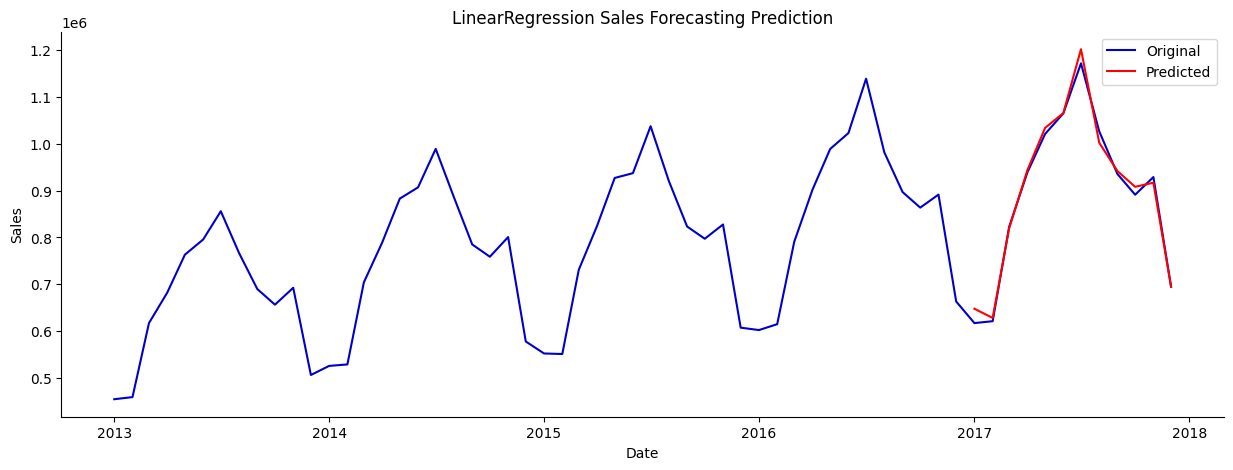

In [23]:
run_model(train, test, LinearRegression(), 'LinearRegression')

# Random Forest Regressor

RMSE: 19569.64027943965
MAE: 16407.0
R2 Score: 0.9864866614206999


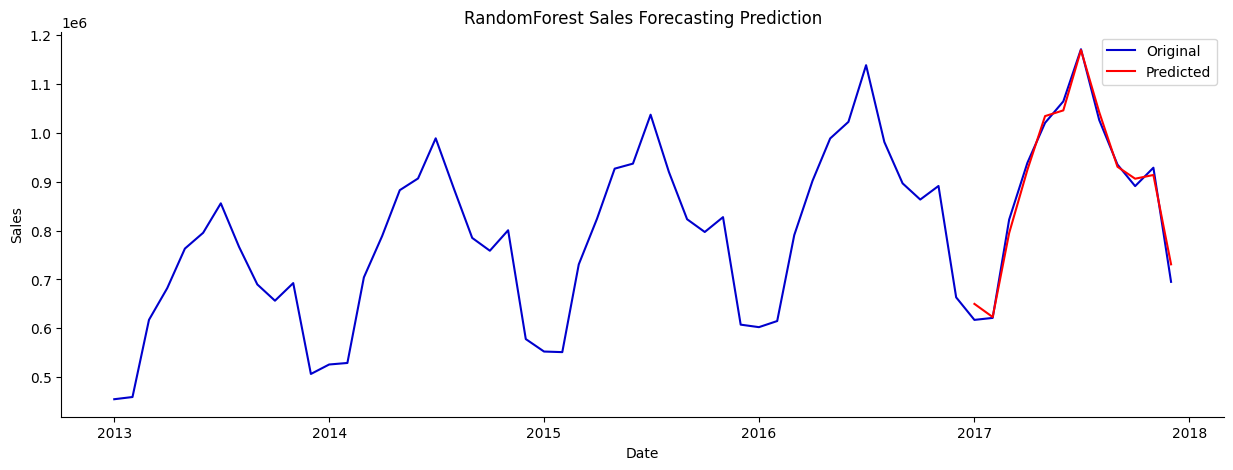

In [24]:
run_model(train, test, RandomForestRegressor(n_estimators=100, max_depth=20), 
          'RandomForest')

# XGBoost

RMSE: 25920.433602983314
MAE: 19914.833333333332
R2 Score: 0.9762927326532191


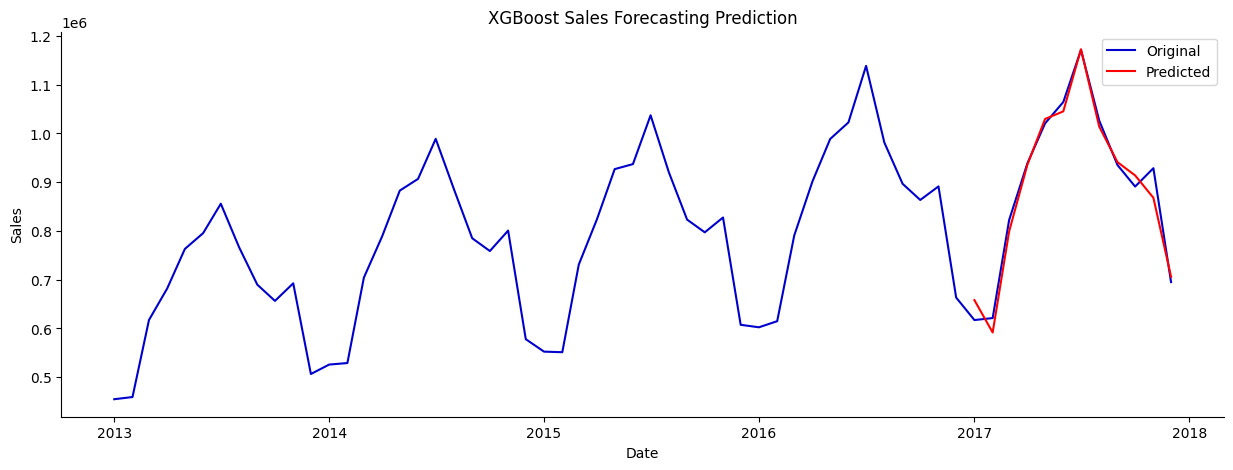

In [25]:
run_model(train, test, XGBRegressor( n_estimators=100, 
                                    learning_rate=0.2, 
                                    objective='reg:squarederror'), 'XGBoost')

# LSTM

In [26]:
def lstm_model(train_data, test_data):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
   
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), 
                   stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, 
              shuffle=False)
    predictions = model.predict(X_test,batch_size=1)
    
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object, lstm=True)
    unscaled_df = predict_df(unscaled, original_df)
    
    get_scores(unscaled_df, original_df, 'LSTM')
    
    plot_results(unscaled_df, original_df, 'LSTM')



Epoch 1/200

35/35 [==============================] - 4s 5ms/step - loss: 0.4084
Epoch 2/200
35/35 [==============================] - 0s 4ms/step - loss: 0.3274
Epoch 3/200
35/35 [==============================] - 0s 4ms/step - loss: 0.2968
Epoch 4/200
35/35 [==============================] - 0s 3ms/step - loss: 0.2698
Epoch 5/200
35/35 [==============================] - 0s 3ms/step - loss: 0.2456
Epoch 6/200
35/35 [==============================] - 0s 4ms/step - loss: 0.2243
Epoch 7/200
35/35 [==============================] - 0s 3ms/step - loss: 0.2053
Epoch 8/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1883
Epoch 9/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1730
Epoch 10/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1590
Epoch 11/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1464
Epoch 12/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1347
Epoch 13/200
35/35 [==============

35/35 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 95/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 96/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 97/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 98/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 99/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 100/200
35/35 [==============================] - 0s 4ms/step - loss: 0.0038
Epoch 101/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 102/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 103/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 104/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 105/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 106/200
35/35 [==============

35/35 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 195/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 196/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 197/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 198/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 199/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 200/200
12/12 [==============================] - 1s 3ms/step
RMSE: 18016.34072862744
MAE: 15382.083333333334
R2 Score: 0.9885467129293816


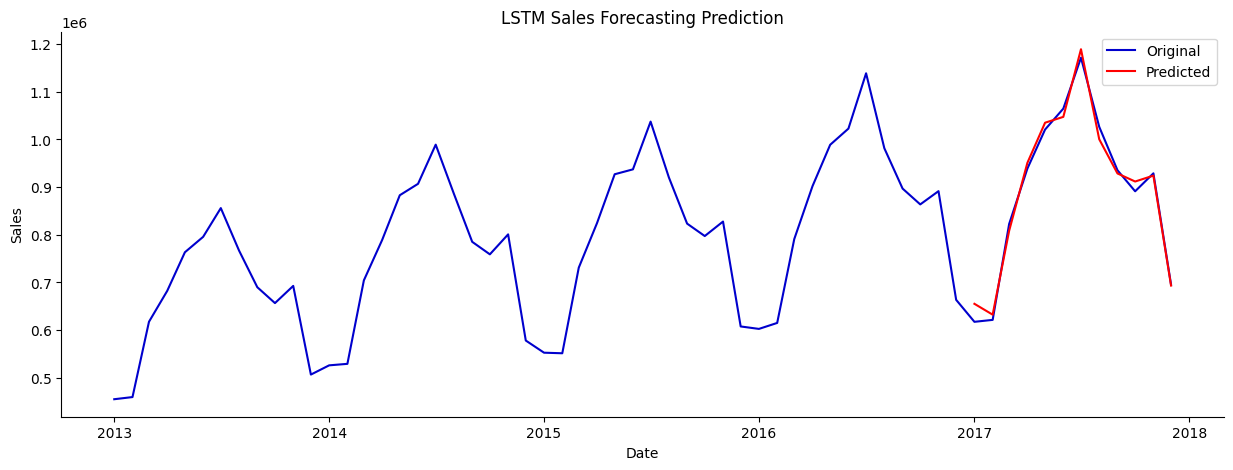

In [27]:
lstm_model(train, test)

In [28]:
pickle.dump(model_scores, open( "model_scores.p", "wb" ) )